In [1]:
import os
os.chdir("../../../")

In [2]:
os.environ['CUDA_VISIBLE_DEVICES'] = '2'

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
import scanpy as sc
import scnet as sn

Using TensorFlow backend.


In [5]:
sc.settings.set_figure_params(dpi=200)

In [6]:
condition_key = "study"
cell_type_key = 'celltype'
target_conditions = ['Batch8', 'Batch9']

# Loading four Toy datasets and data preparation

In [7]:
path_to_save = "./results/toy/"
os.makedirs(path_to_save, exist_ok=True)

In [8]:
sc.settings.figdir = path_to_save

In [9]:
adata = sc.read("./data/toy/toy_normalized.h5ad")
adata

AnnData object with n_obs × n_vars = 36000 × 2000 
    obs: 'study', 'celltype', 'n_counts', 'size_factors'
    var: 'n_counts'

## Number of cells in each batch

In [10]:
adata.obs[condition_key].value_counts()

Batch9    4000
Batch8    4000
Batch7    4000
Batch6    4000
Batch5    4000
Batch4    4000
Batch3    4000
Batch2    4000
Batch1    4000
Name: study, dtype: int64

## visualization  of the original data

In [11]:
adata.X.min(), adata.X.max()

(0.0, 7.5084276)

In [12]:
# sc.pp.neighbors(adata)
# sc.tl.umap(adata, min_dist=2.0)

In [13]:
# sc.pl.umap(adata, color=condition_key, wspace=0.5, frameon=False, palette=sc.pl.palettes.godsnot_102[5:],
#            save="_original_condition.pdf")

In [14]:
# sc.pl.umap(adata, color=cell_type_key, wspace=0.5, frameon=False, palette=sc.pl.palettes.zeileis_28,
#            save="_original_cell_type.pdf")

## Now we leave out one study (SS2) for training the newtork

In [15]:
adata_for_training = adata[~adata.obs[condition_key].isin(target_conditions)]
adata_for_training

View of AnnData object with n_obs × n_vars = 28000 × 2000 
    obs: 'study', 'celltype', 'n_counts', 'size_factors'
    var: 'n_counts'

In [16]:
adata_out_of_sample = adata[adata.obs[condition_key].isin(target_conditions)]
adata_out_of_sample

View of AnnData object with n_obs × n_vars = 8000 × 2000 
    obs: 'study', 'celltype', 'n_counts', 'size_factors'
    var: 'n_counts'

## Train/Test Split

In [17]:
train_adata, valid_adata = sn.utils.train_test_split(adata_for_training, 0.85)

In [18]:
train_adata.shape, valid_adata.shape

((23800, 2000), (4200, 2000))

In [19]:
n_conditions = len(train_adata.obs[condition_key].unique().tolist())
n_conditions

7

# Create & Train model with training data

In [20]:
network = sn.archs.CVAE(x_dimension=train_adata.shape[1], 
                             z_dimension=10,
                             architecture=[512, 64, 32],
                             n_conditions=n_conditions,
                             use_batchnorm=False,
                             lr=0.001,
                             alpha=0.00001,
                             beta=0.1,
                             eta=1.0,
                             clip_value=100,
                             loss_fn='mse',
                             model_path="./models/CVAE/toy/before/",
                             dropout_rate=0.2,
                            )

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


## We assign each study to a numerical label 

In [21]:
conditions = adata.obs[condition_key].unique().tolist()
condition_encoder = sn.utils.create_dictionary(conditions, target_conditions)
condition_encoder

{'Batch1': 0,
 'Batch2': 1,
 'Batch3': 2,
 'Batch4': 3,
 'Batch5': 4,
 'Batch6': 5,
 'Batch7': 6}

## Training the network

In [22]:
network.train(train_adata,
              valid_adata, 
              condition_key=condition_key,
              le=condition_encoder, 
              n_epochs=1000,
              batch_size=128, 
              early_stop_limit=30,
              lr_reducer=20,
              n_per_epoch=0,
              save=True, 
              retrain=False,
              verbose=5)

Model has been successfully restored!


In [23]:
network.condition_encoder

{'Batch1': 0,
 'Batch2': 1,
 'Batch3': 2,
 'Batch4': 3,
 'Batch5': 4,
 'Batch6': 5,
 'Batch7': 6}

In [24]:
encoder_labels, _ = sn.utils.label_encoder(
    adata_for_training, label_encoder=network.condition_encoder, condition_key=condition_key)

In [30]:
latent_adata = network.to_latent(adata_for_training, encoder_labels)
latent_adata

AnnData object with n_obs × n_vars = 28000 × 10 
    obs: 'batch', 'celltype', 'size_factors'

In [31]:
sc.pp.neighbors(latent_adata)
sc.tl.umap(latent_adata)

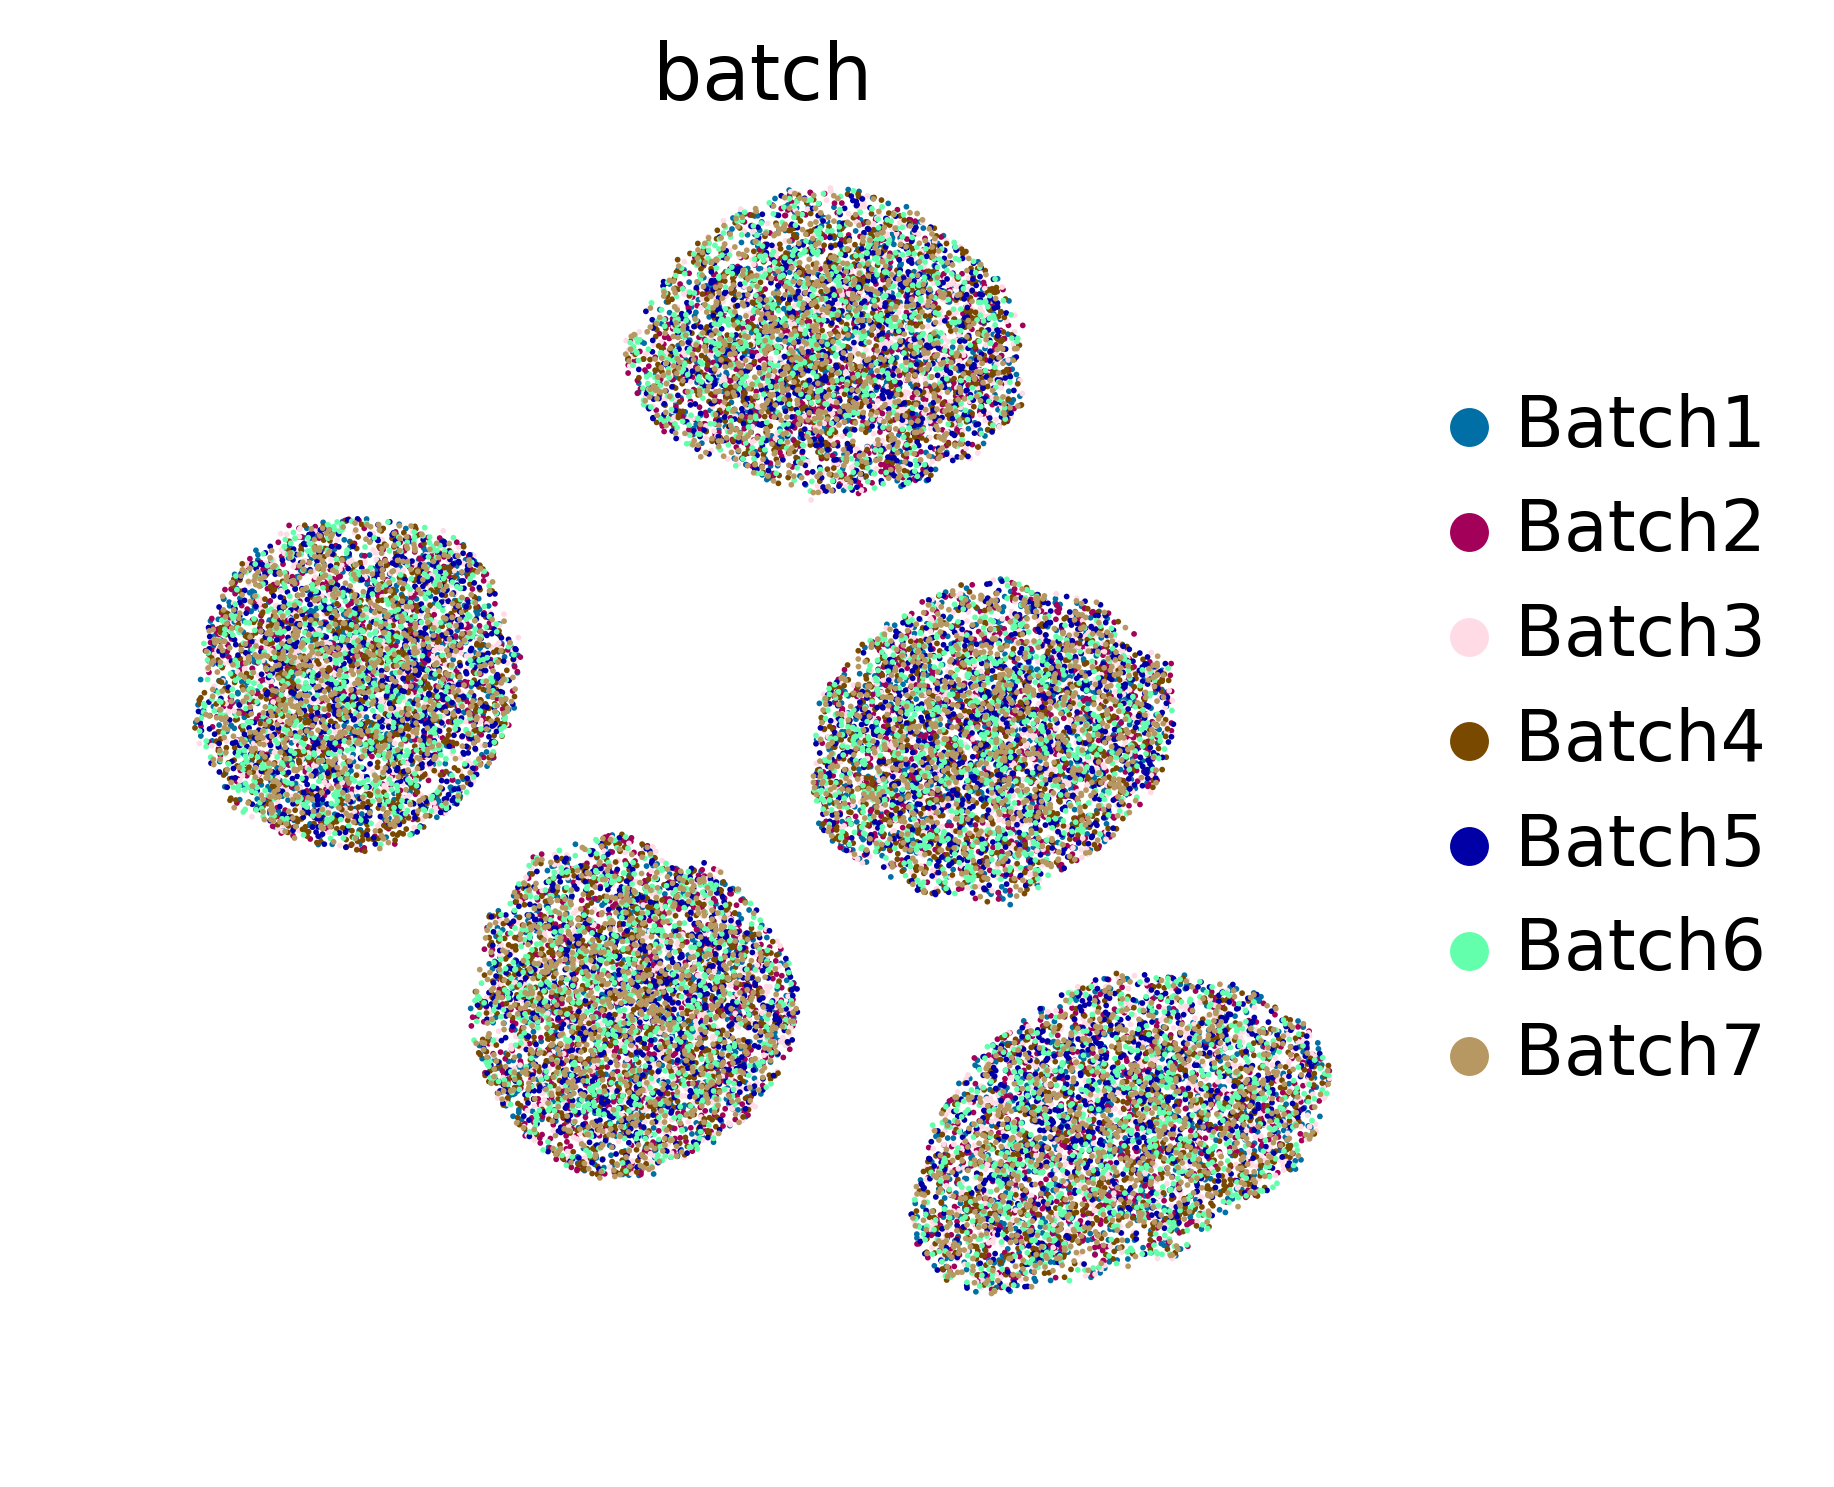

In [32]:
sc.pl.umap(latent_adata, color=condition_key, wspace=0.5, frameon=False, palette=sc.pl.palettes.godsnot_102[5:],
           save="_pretrained_condition.pdf")

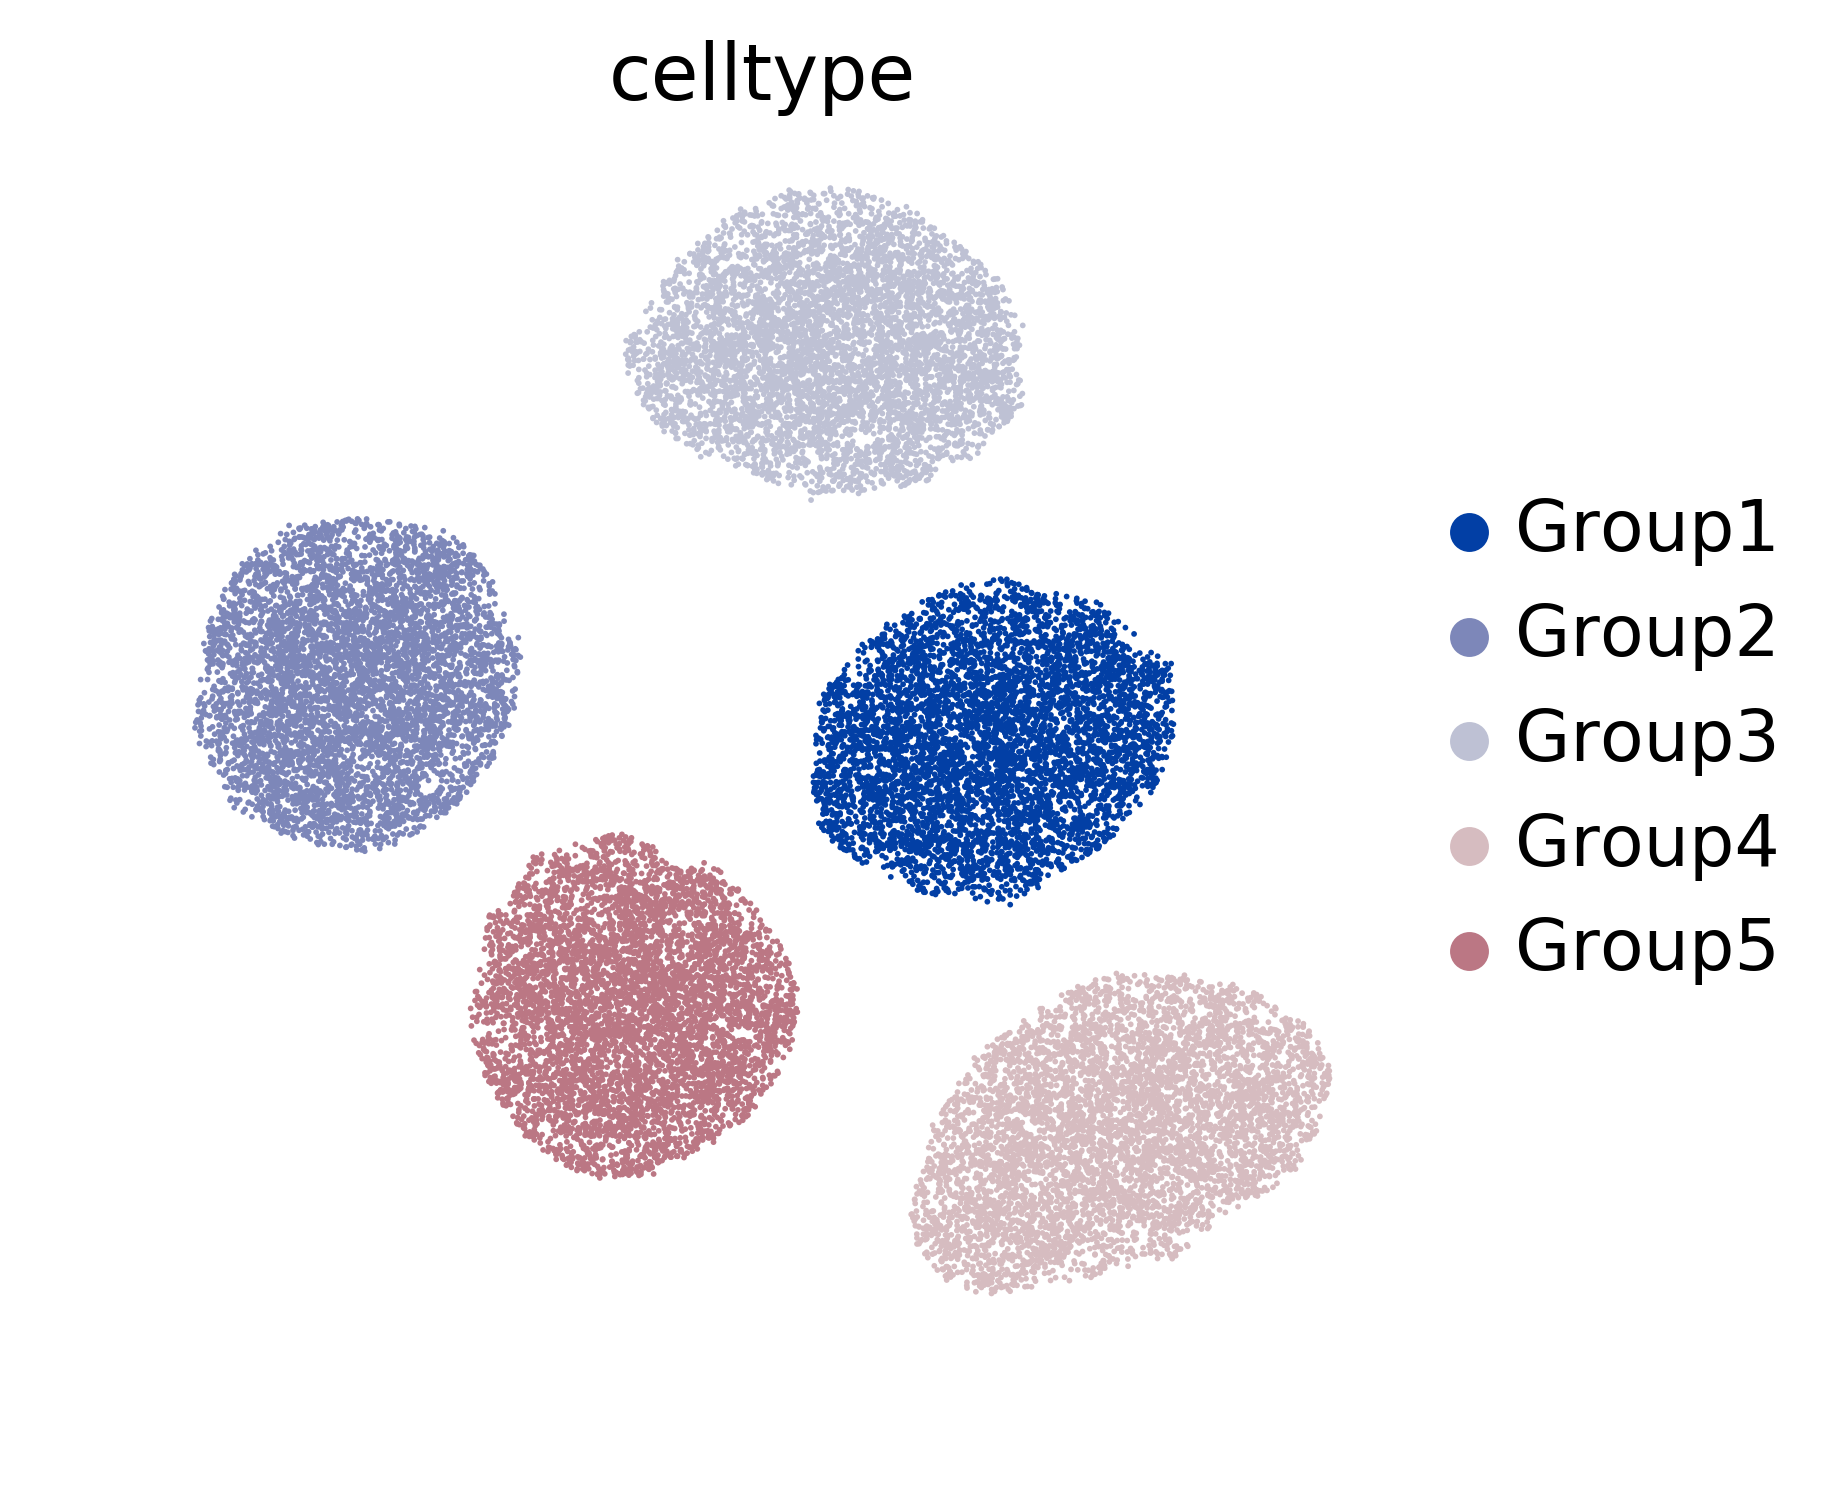

In [33]:
sc.pl.umap(latent_adata, color=cell_type_key, wspace=0.5, frameon=False, palette=sc.pl.palettes.zeileis_28,
           save="_pretrained_cell_type.pdf")

# Perfroming architecture Surgery

In [25]:
new_network = sn.operate(network, 
                              new_conditions=target_conditions,
                              freeze_expression_input=True,
                              remove_dropout=True,
                              init='Xavier', 
                              freeze=True)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               (None, 2000)         0                                            
__________________________________________________________________________________________________
encoder_labels (InputLayer)     (None, 9)            0                                            
__________________________________________________________________________________________________
first_layer (FirstLayer)        (None, 512)          1028608     data[0][0]                       
                                                                 encoder_labels[0][0]             
__________________________________________________________________________________________________
leaky_re_lu_7 (LeakyReLU)       (None, 512)          0           first_layer[0][0]                
__________

In [26]:
new_network.condition_encoder

{'Batch1': 0,
 'Batch2': 1,
 'Batch3': 2,
 'Batch4': 3,
 'Batch5': 4,
 'Batch6': 5,
 'Batch7': 6,
 'Batch8': 7,
 'Batch9': 8}

In [27]:
new_network.model_path = './models/CVAE/toy/after/'

## Train with small new dataset containing out-of-sample condition

In [28]:
train_adata, valid_adata = sn.utils.train_test_split(adata_out_of_sample, 0.80)

In [29]:
train_adata.shape, valid_adata.shape

((6400, 2000), (1600, 2000))

In [30]:
new_network.train(train_adata,
                  valid_adata, 
                  condition_key=condition_key,
                  le=new_network.condition_encoder, 
                  n_epochs=1000,
                  batch_size=128,
                  early_stop_limit=30,
                  lr_reducer=20,
                  n_per_epoch=0,
                  save=True,
                  retrain=False,
                  verbose=5)

Model has been successfully restored!


In [31]:
encoder_labels, _ = sn.utils.label_encoder(adata_out_of_sample, label_encoder=new_network.condition_encoder, condition_key=condition_key)
encoder_labels.shape

(8000, 1)

In [32]:
latent_adata = new_network.to_latent(adata_out_of_sample, encoder_labels)
latent_adata

AnnData object with n_obs × n_vars = 8000 × 10 
    obs: 'study', 'celltype', 'n_counts', 'size_factors'

In [33]:
sc.pp.neighbors(latent_adata)
sc.tl.umap(latent_adata)

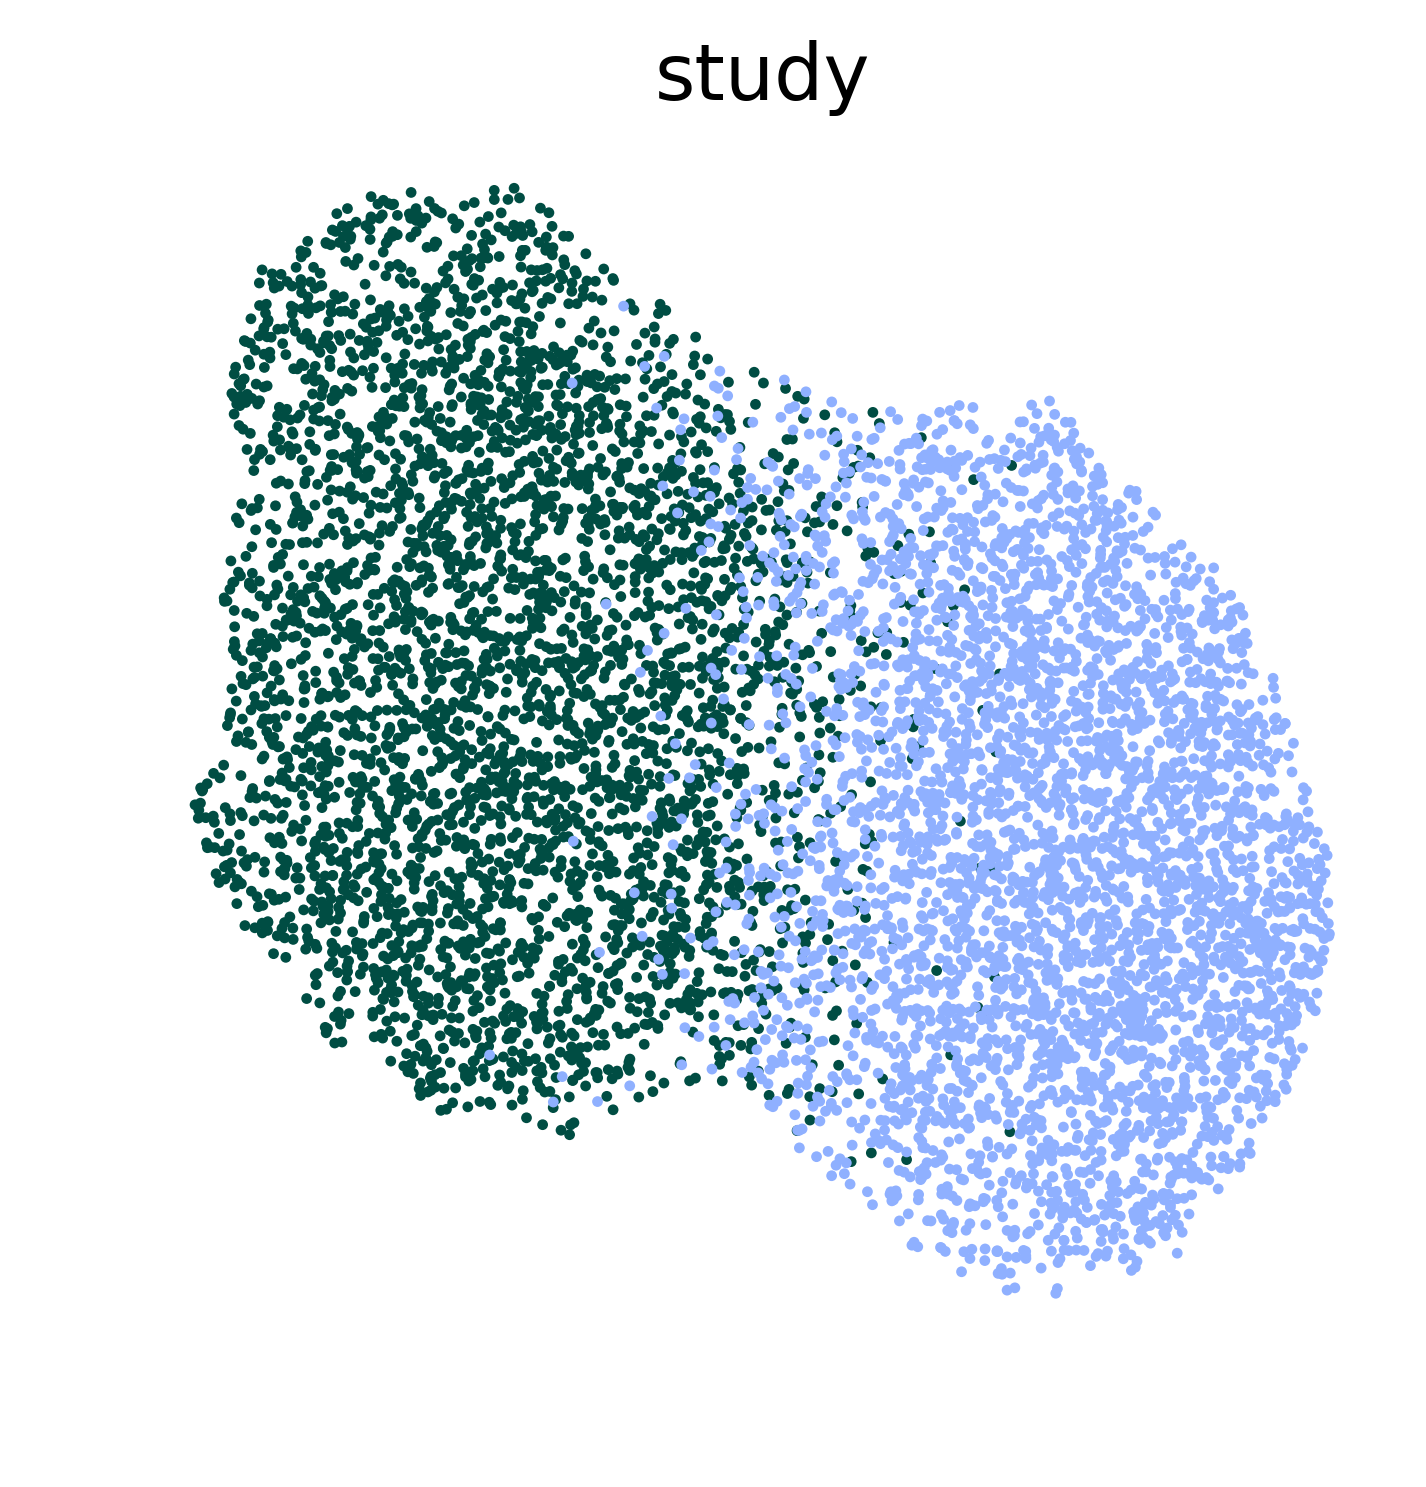

In [34]:
sc.pl.umap(latent_adata, color=condition_key, wspace=0.5, frameon=False, palette=sc.pl.palettes.godsnot_102[5+7:],
           save="_after_surgery_condition.pdf", legend_loc=None)

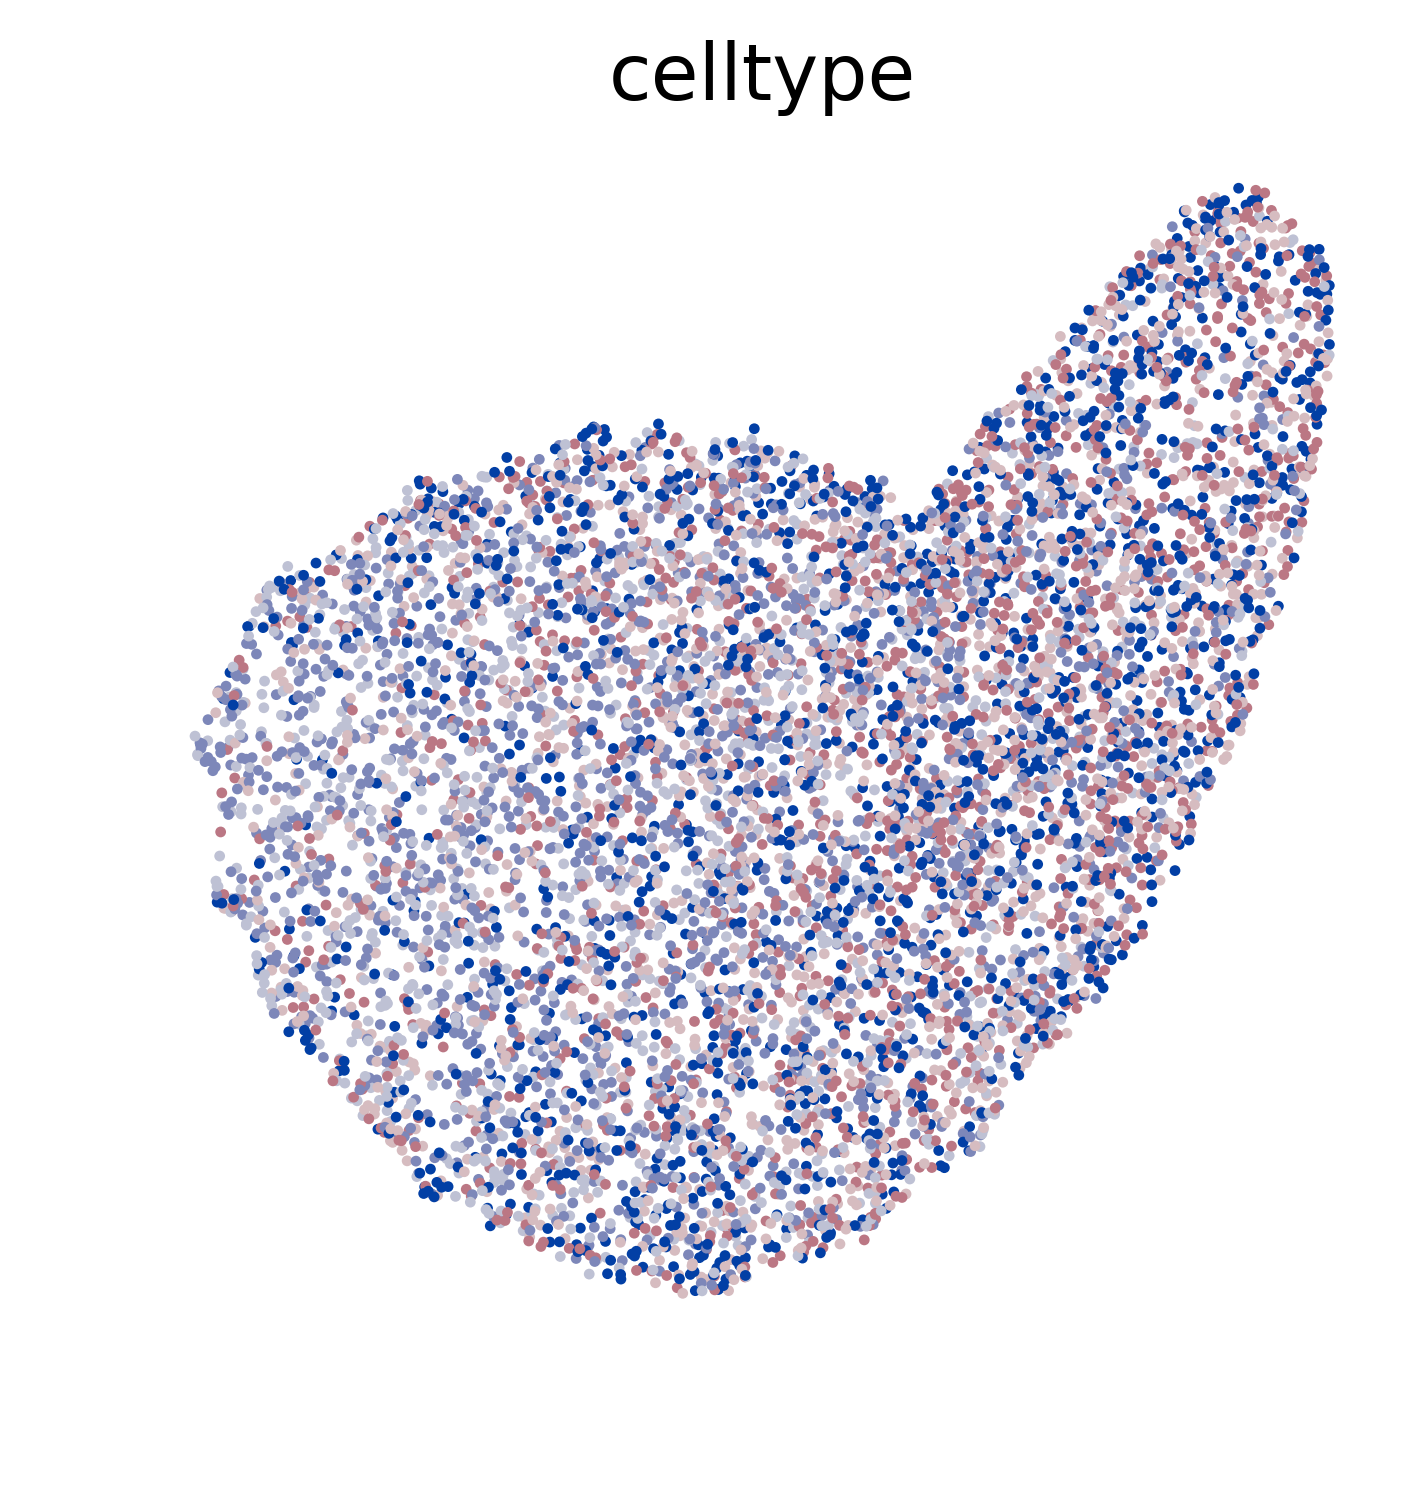

In [49]:
sc.pl.umap(latent_adata, color=cell_type_key, wspace=0.5, frameon=False, palette=sc.pl.palettes.zeileis_28,
           save="_after_surgery_cell_type.pdf", legend_loc=None)

In [50]:
encoder_labels, _ = sn.utils.label_encoder(adata, label_encoder=new_network.condition_encoder, condition_key=condition_key)
encoder_labels.shape

(36000, 1)

In [51]:
latent_adata = new_network.to_latent(adata, encoder_labels)
latent_adata

AnnData object with n_obs × n_vars = 36000 × 10 
    obs: 'batch', 'celltype', 'size_factors'

In [52]:
sc.pp.neighbors(latent_adata)
sc.tl.umap(latent_adata)

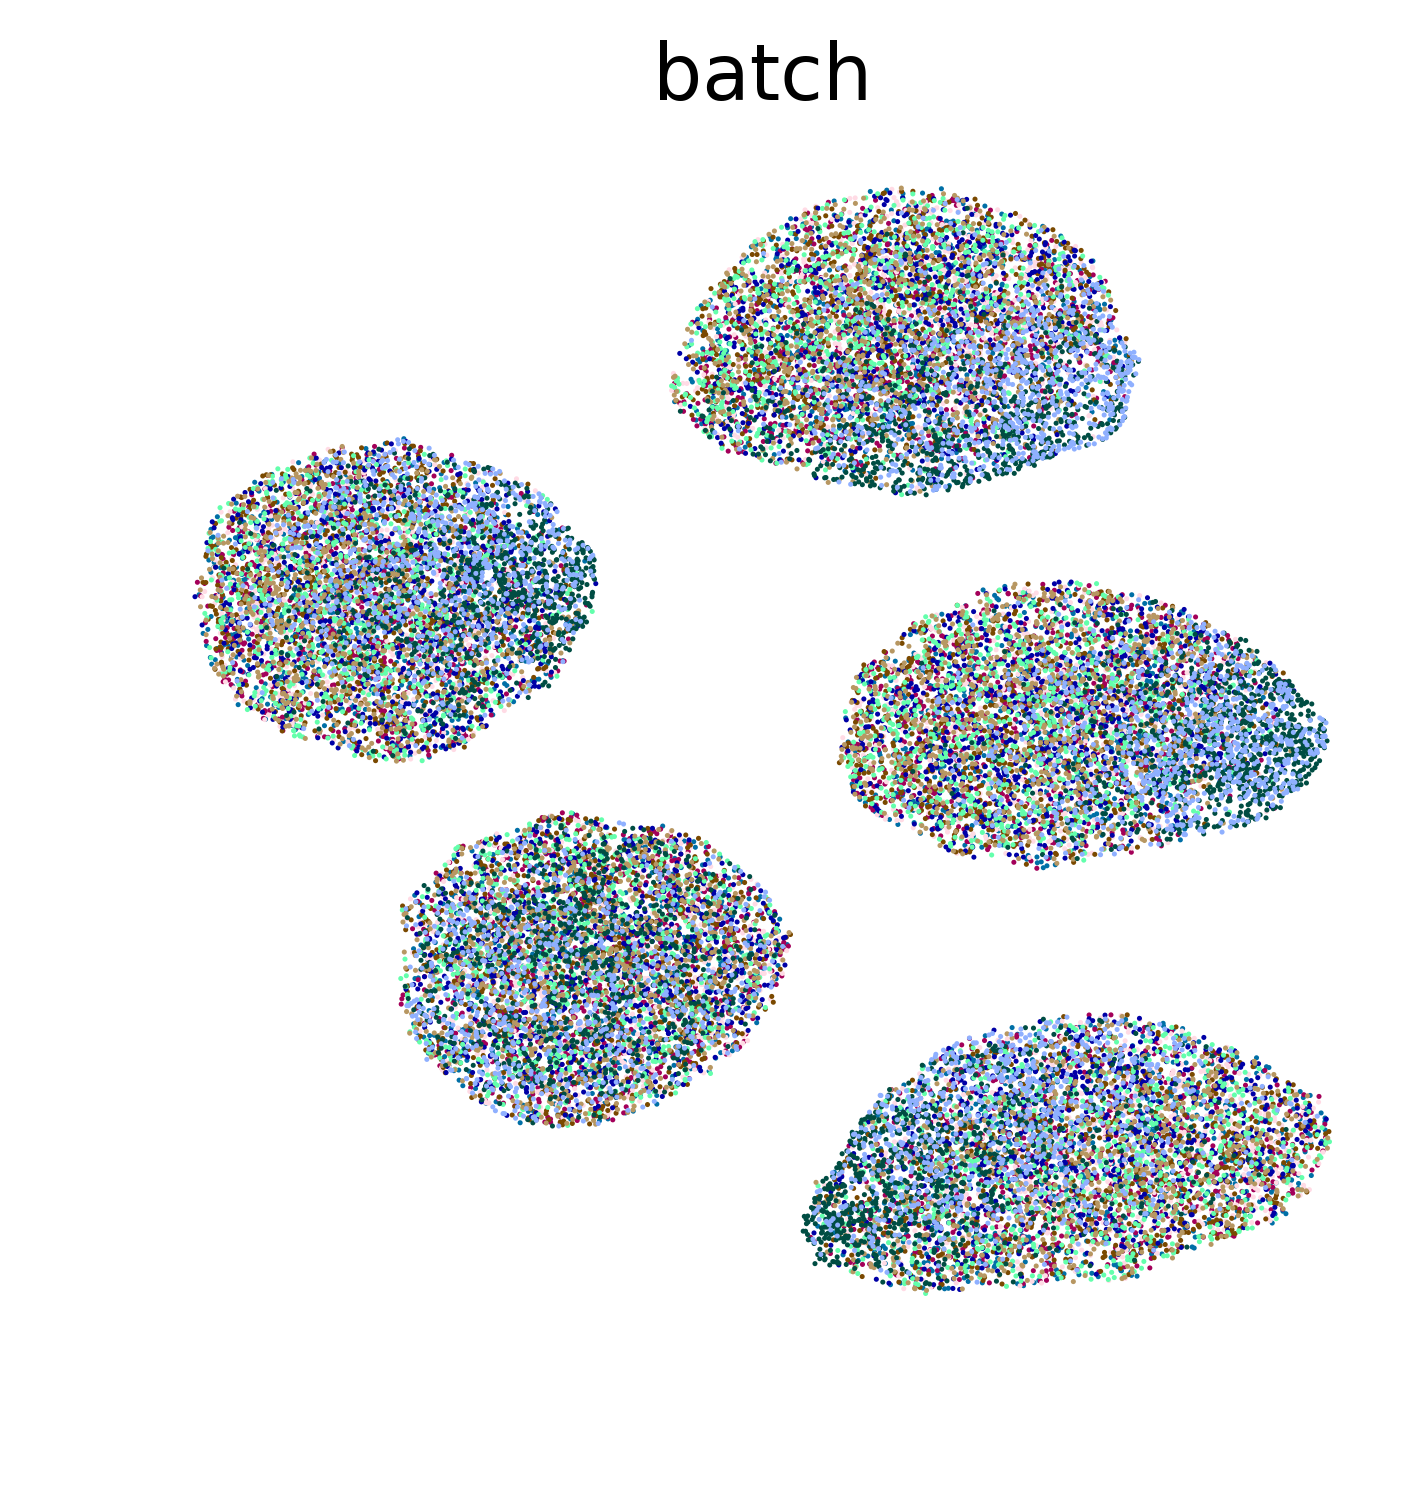

In [53]:
sc.pl.umap(latent_adata, color=condition_key, wspace=0.5, frameon=False, palette=sc.pl.palettes.godsnot_102[5:],
           save="_after_surgery_all_condition.pdf", legend_loc=None)

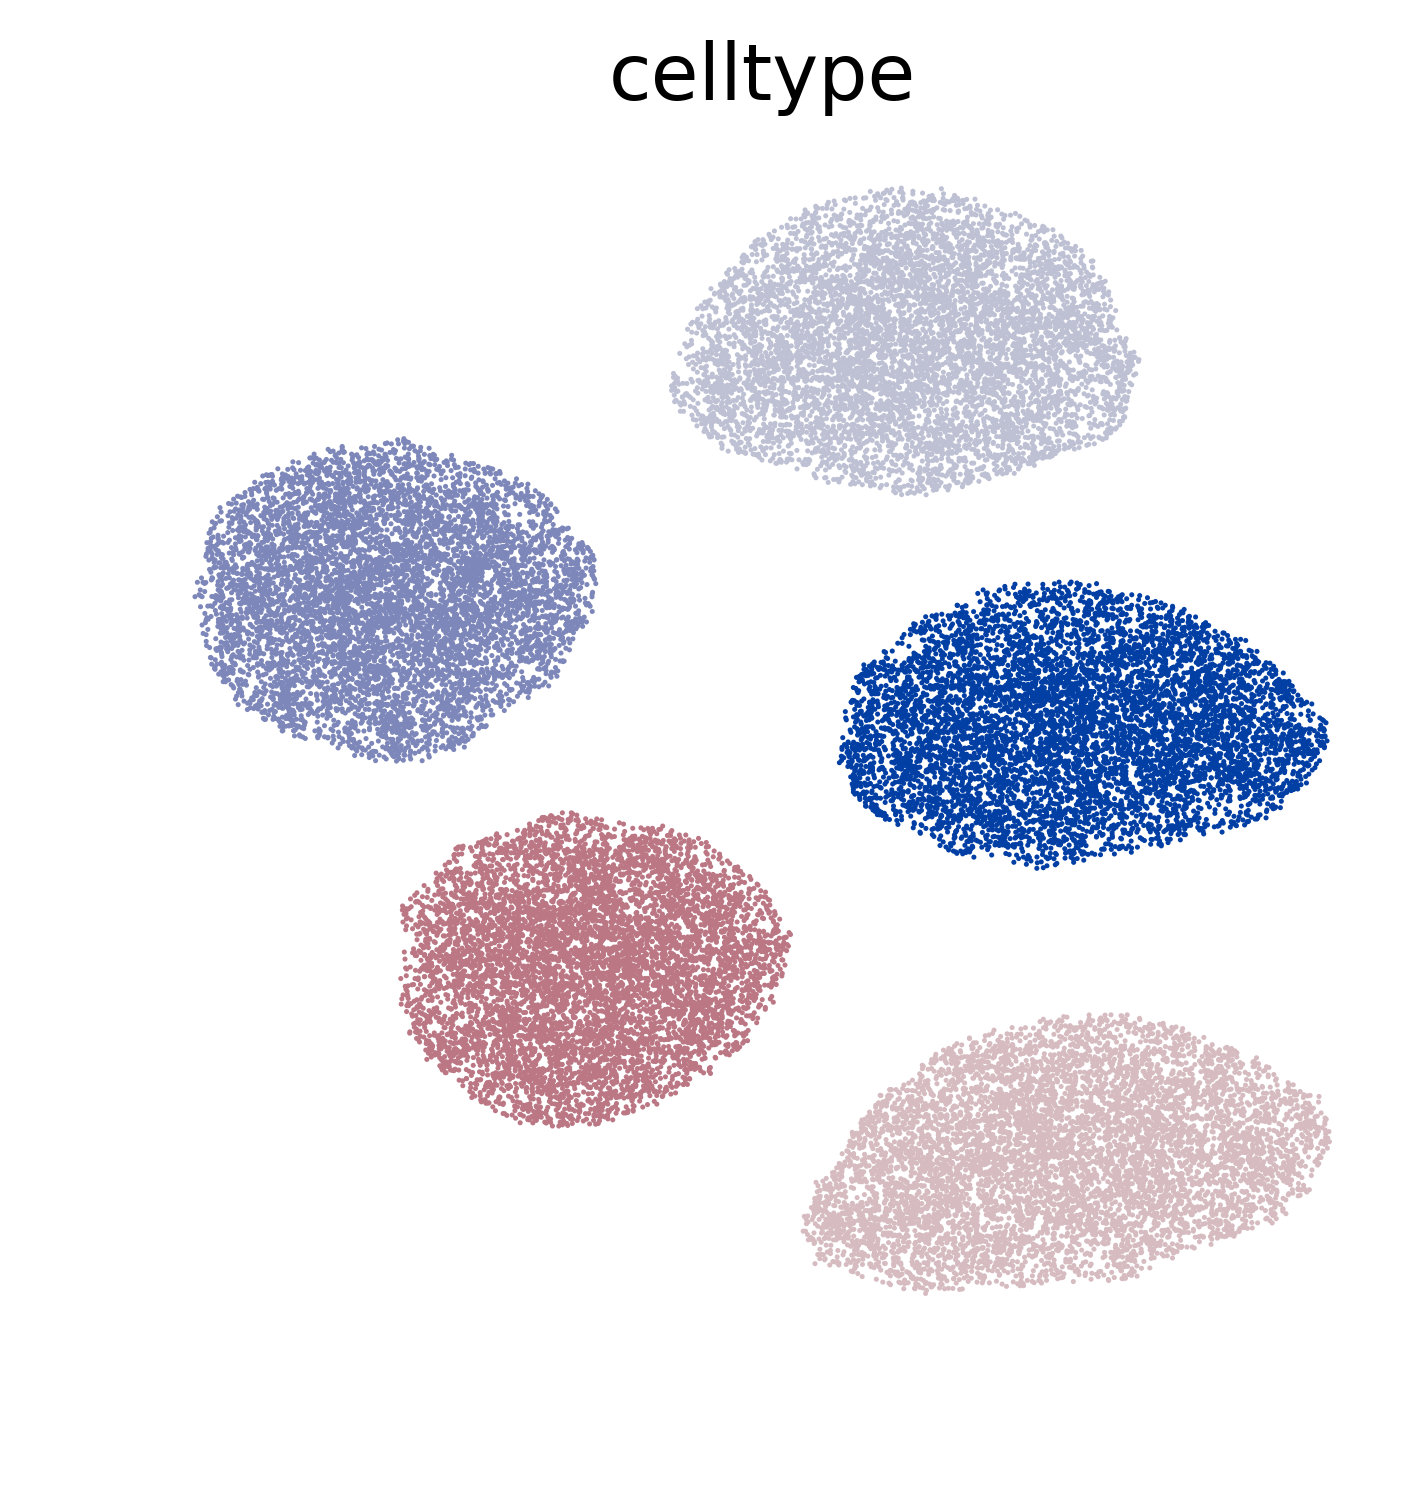

In [54]:
sc.pl.umap(latent_adata, color=cell_type_key, wspace=0.5, frameon=False, palette=sc.pl.palettes.zeileis_28,
           save="_after_surgery_all_cell_type.pdf", legend_loc=None)